# PubMed-RCT 200K <i>paper-replication</i>

In [1]:
import tensorflow as tf
tf.__version__

2024-06-26 21:04:45.989316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 21:04:45.989373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 21:04:46.027219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 21:04:46.110416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 21:04:47.098792: W tensorflow/compiler/tf2

'2.15.1'

In [2]:
from helper_functions import calculate_results

## Become one with thee data

In [3]:
!ls pubmed-rct/

PubMed_200k_RCT/
PubMed_200k_RCT_numbers_replaced_with_at_sign/
PubMed_20k_RCT/
PubMed_20k_RCT_numbers_replaced_with_at_sign/
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# dev = validation
train_10_lem_path = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
test_10_lem_path = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt"
dev_10_lem_path = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt"

In [6]:
train_10_lem = open(train_10_lem_path).read()
print(train_10_lem[:100])

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in 


for abstract in train_10_lem[3:].split("\n\n###"):
    background, objective, methods, results, conclusions = [None], [None], [None], [None], [None]
    abstract = abstract.split('\n')
    abstract_id = int(abstract[0])
    for sentence in abstract:
        if sentence.startswith("BACKGROUND\t"):
            background.append(sentence[12:])
        elif sentence.startswith("OBJECTIVE\t"):
            objective.append(sentence[10:])
        elif sentence.startswith("METHODS\t"):
            methods.append(sentence[8:])
        elif sentence.startswith("RESULTS\t"):
            results.append(sentence[8:])
        elif sentence.startswith("CONCLUSIONS\t"):
            conclusions.append(sentence[13:])
    print(pd.DataFrame({"id": abstract_id, "background": background, "objective": objective, "methods": methods, "results": results, "conclusions":conclusions}))
    # pd.concat([train_10_lem_df, pd.DataFrame({"id": abstract_id, "background": background, "objective": objective, "methods": methods, "results": results, "conclusions":conclusions})])

In [7]:
with open(train_10_lem_path) as f:
    train_lines = f.readlines()

In [8]:
train_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

[{
    'line_number': int,
    'target': str,
    'text': str,
    'total_lines': int
}, 
{
    ...
}
]

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  with open(filename) as f: input_lines = f.readlines()  
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
train_samples = preprocess_text_with_line_numbers(train_10_lem_path)
val_samples = preprocess_text_with_line_numbers(dev_10_lem_path)
test_samples = preprocess_text_with_line_numbers(test_10_lem_path)

In [11]:
train_samples[:13]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [14]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [15]:
train_df.total_lines.value_counts() # avg

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

In [16]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [17]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

### Make numeric labels

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1, 1))

train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [19]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Label encode

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

## Models

### Model0: Naive Bayes

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
history = model_0.fit(train_sentences, train_labels_encoded)

In [22]:
model_0_preds = history.predict(test_sentences,)

In [23]:
from helper_functions import calculate_results
model_0_results = calculate_results(
    test_labels_encoded,
    model_0_preds
)
model_0_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

### Model1: Conv1D + token embbedings

In [24]:
from tensorflow.keras.layers import TextVectorization

# use default TextVectorization parameters
vocab_length =  70_000
max_length = 50
text_vectorizer = TextVectorization(
  max_tokens=vocab_length, # How many words are in vocab
  standardize="lower_and_strip_punctuation",
  output_mode="int", # How to map words to num
  output_sequence_length=max_length, # how long does sequences will be
  pad_to_max_tokens=True
)

2024-06-26 21:05:00.861169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 21:05:01.046812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 21:05:01.047143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [25]:
text_vectorizer.adapt(train_sentences)

In [26]:
sample_sentence = "Hello, my name is Borak, nice to meet you!"
text_vectorizer([sample_sentence])

2024-06-26 21:05:11.985460: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[    1, 25624,  9118,    20,     1,  7329,     6,  2807, 10096,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])>

In [27]:
embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=512,
    input_length=max_length,
    mask_zero=True
)

#### Creating tf datasets 

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [29]:
# Prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#### Creating model

In [30]:
# Create a model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [31]:
model_1.compile(
    optimizer="Adam",
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [32]:
history_1 = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    validation_steps=len(val_sentences),
    epochs=5
)

Epoch 1/5


2024-06-26 21:05:50.394502: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-26 21:05:50.700428: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-26 21:05:51.058276: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe124da8ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-26 21:05:51.058346: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-26 21:05:51.088668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719425151.235982    3872 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5627/5627 [==============================] - 134s 23ms/step - loss: 0.5886 - accuracy: 0.7870 - val_loss: 0.5293 - val_accuracy: 0.8105
Epoch 2/5
   7/5627 [..............................] - ETA: 1:50 - loss: 0.5982 - accuracy: 0.7902

2024-06-26 21:08:03.516582: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10691324595616781284
2024-06-26 21:08:03.516644: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7418058887113019749
2024-06-26 21:08:03.516669: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13068221281480751637
2024-06-26 21:08:03.516680: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15321840845383745233
2024-06-26 21:08:03.516696: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12806813954593337301


5627/5627 [==============================] - 105s 19ms/step - loss: 0.4219 - accuracy: 0.8528
Epoch 3/5
5627/5627 [==============================] - 105s 19ms/step - loss: 0.3142 - accuracy: 0.8944
Epoch 4/5
5627/5627 [==============================] - 109s 19ms/step - loss: 0.2244 - accuracy: 0.9278
Epoch 5/5
5627/5627 [==============================] - 105s 19ms/step - loss: 0.1602 - accuracy: 0.9508


In [33]:
model_1_pred_probs = model_1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

942/942 [==============================] - 4s 4ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 4, 2, ..., 4, 4, 4])>

In [34]:
model_1_results = calculate_results(
    test_labels_encoded,
    model_1_preds
)

In [35]:
model_1_results

{'accuracy': 77.2755931640949,
 'precision': 0.7700241964363143,
 'recall': 0.772755931640949,
 'f1': 0.7708521794447235}

### Model2: Feature extraction with pretrained embeddings

In [36]:
import tensorflow_hub as tfhub
USE_embedding = tfhub.KerasLayer(
    "../USE", 
    trainable=False,
    input_shape = [],
    dtype = tf.string,
)

In [37]:
inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
x = USE_embedding(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

In [38]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [39]:
history_2 = model_2.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    validation_steps=len(val_sentences)
)

Epoch 1/5
5621/5627 [============================>.] - ETA: 0s - loss: 0.7309 - accuracy: 0.7209WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30212 batches). You may need to use the repeat() function when building your dataset.


2024-06-26 21:16:12.476578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18243478635263394232
2024-06-26 21:16:12.476618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12139284875124044728
2024-06-26 21:16:12.476626: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16028272755198971070
2024-06-26 21:16:12.476633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 837842833262069979
2024-06-26 21:16:12.476641: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8166041400215162893
2024-06-26 21:16:12.476648: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11853381352475896567
2024-06-26 21:16:12.476654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

5627/5627 [==============================] - 56s 9ms/step - loss: 0.7308 - accuracy: 0.7210 - val_loss: 0.6594 - val_accuracy: 0.7482
Epoch 2/5
5627/5627 [==============================] - 43s 8ms/step - loss: 0.6386 - accuracy: 0.7581
Epoch 3/5
5627/5627 [==============================] - 43s 8ms/step - loss: 0.6034 - accuracy: 0.7720
Epoch 4/5
5627/5627 [==============================] - 43s 8ms/step - loss: 0.5802 - accuracy: 0.7814
Epoch 5/5
5627/5627 [==============================] - 44s 8ms/step - loss: 0.5626 - accuracy: 0.7884


In [40]:
model_2_preds = tf.argmax(model_2.predict(val_dataset), axis=1)
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

945/945 [==============================] - 7s 7ms/step


{'accuracy': 77.3732291804581,
 'precision': 0.7721113302088481,
 'recall': 0.7737322918045809,
 'f1': 0.7698780362463314}

### Model3: Conv1D with char embedding

In [41]:
USE_embedding(["h", "e", "l", "l", "o"])

<tf.Tensor: shape=(5, 512), dtype=float32, numpy=
array([[-0.03142553, -0.01687619,  0.02631524, ..., -0.07626341,
         0.00296729,  0.04952101],
       [ 0.0203605 , -0.07000163,  0.04469849, ..., -0.07390847,
        -0.02310359, -0.01881832],
       [ 0.02793263, -0.05721048,  0.01098407, ..., -0.09221515,
         0.04151777,  0.00654545],
       [ 0.0279326 , -0.05721049,  0.01098406, ..., -0.09221514,
         0.04151776,  0.00654545],
       [ 0.05602327, -0.04955822,  0.06383324, ..., -0.0794097 ,
         0.03333949,  0.04332928]], dtype=float32)>

In [42]:
def split_chars(seq):
    return " ".join(list(seq))

In [43]:
train_chars = [split_chars(seq) for seq in train_sentences]
val_chars = [split_chars(seq) for seq in val_sentences]
test_chars = [split_chars(seq) for seq in test_sentences]

In [44]:
import numpy as np
char_lens = [len(i) for i in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

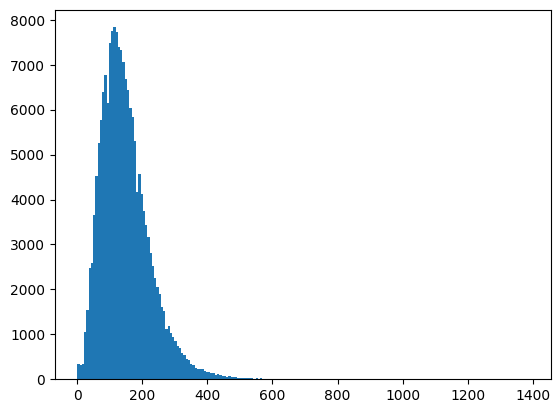

In [45]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=200);

In [46]:
# 95%
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [47]:
import string
alphabet = string.ascii_lowercase + \
string.digits + string.punctuation # + space + UNK

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [48]:
from keras  import layers
max_tokens = len(alphabet) + 2
char_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_char_len,
    standardize="lower_and_strip_punctuation"
)
char_vectorizer.adapt(train_chars)

In [49]:
char_embed = layers.Embedding(
    input_dim=max_tokens,
    output_dim=25, # embedding dimension of each character
    mask_zero=False, # don't use masks (this messes up model_5 if set to True)
)

char_embed(char_vectorizer([train_chars[0]])).shape

TensorShape([1, 290, 25])

In [50]:
# Building the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [51]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",    
    metrics=["accuracy"])

In [52]:

# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [53]:
history_3 = model_3.fit(
    train_char_dataset,
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=len(val_char_dataset)
)

Epoch 1/3
5627/5627 [==============================] - 34s 6ms/step - loss: 1.3108 - accuracy: 0.4502 - val_loss: 1.2437 - val_accuracy: 0.4887
Epoch 2/3
5627/5627 [==============================] - 31s 6ms/step - loss: 1.2172 - accuracy: 0.5000 - val_loss: 1.1681 - val_accuracy: 0.5228
Epoch 3/3
5627/5627 [==============================] - 32s 6ms/step - loss: 1.1334 - accuracy: 0.5418 - val_loss: 1.0805 - val_accuracy: 0.5671


In [54]:
model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1)

945/945 [==============================] - 3s 3ms/step


In [55]:
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 2, 0])>

In [56]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

In [57]:
model_3_results

{'accuracy': 56.705944657751886,
 'precision': 0.5379994924175261,
 'recall': 0.5670594465775188,
 'f1': 0.5398086454376365}

### Model4: (USE + char_embed) = hybrid embed layer

In [58]:
# token embedding
token_embedding_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = USE_embedding(token_embedding_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(x)
token_embedding_model = tf.keras.Model(token_embedding_inputs, token_outputs)

# char embedding
char_embedding_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
y = char_vectorizer(char_embedding_inputs)
y = char_embed(y)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(y)
char_embedding_model = tf.keras.Model(char_embedding_inputs, char_bi_lstm)

# concatenate
combined = tf.keras.layers.concatenate([token_embedding_model.output, char_embedding_model.output])

#  Create output layers
combined_dropout = layers.Dropout(0.5)(combined)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation='softmax')(final_dropout)

In [59]:
model_4 = tf.keras.Model(
    inputs=[
        token_embedding_model.input,
        char_embedding_model.input
           ],
    outputs=output_layer
)

In [60]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['input_5[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['input_4[0][0]']       

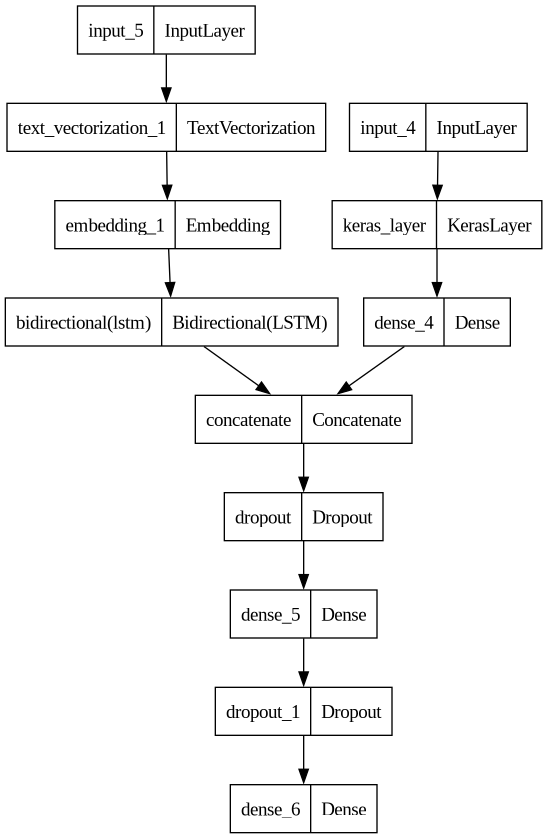

In [61]:
tf.keras.utils.plot_model(model_4)

In [62]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])


In [63]:
# Prepare train_dataset ((train_sentences, train_chars), train_labels_one_hot)
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_4 = model_4.fit(
    train_char_token_dataset,
    epochs=5,
    validation_data=val_char_token_dataset,
    validation_steps=len(val_char_token_dataset)
)

Epoch 1/5
5627/5627 [==============================] - 184s 32ms/step - loss: 0.7550 - accuracy: 0.7118 - val_loss: 0.6204 - val_accuracy: 0.7632
Epoch 2/5
5627/5627 [==============================] - 189s 34ms/step - loss: 0.6706 - accuracy: 0.7472 - val_loss: 0.5963 - val_accuracy: 0.7744
Epoch 3/5
3058/5627 [===============>..............] - ETA: 1:20 - loss: 0.6532 - accuracy: 0.7533

In [ ]:
model_4_preds = tf.argmax(model_4.predict(val_char_token_dataset), axis=1)

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

### Model5: USE_embedding + char_embedding + positional_embedding

In [ ]:
train_df.head()

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();


In [ ]:
np.percentile(train_df.total_lines, 98)

In [ ]:
np.percentile(train_df.line_number, 98)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)

In [ ]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

In [ ]:
from keras import layers

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = USE_embedding(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token + char models
combined_embeddings = layers.Concatenate()([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine pos embeddings with token/char embeddings
z = layers.Concatenate()([line_number_model.output, total_line_model.output, z])

# 7. Output
output_layer = layers.Dense(5, activation="softmax")(z)

# 8. Model_5
model_5 = tf.keras.Model([
    line_number_model.input,
    total_line_model.input,
    token_model.input,
    char_model.input
], output_layer)

In [ ]:
model_5.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Training
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars
))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

In [ ]:
train_pos_char_token_dataset, val_pos_char_token_dataset

In [ ]:
history_model_5 = model_5.fit(
    train_pos_char_token_dataset,
    epochs=5,
    validation_data = val_pos_char_token_dataset,
    validation_steps=len(val_pos_char_token_dataset)
)

In [ ]:
model_5_preds = tf.argmax(model_5.predict(val_pos_char_token_dataset), axis=1)
model_5_preds

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

In [ ]:
model_5.save("model_5_pub_med.keras")

## Compare models

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));